# Import required library packages

In [1]:
!pip install afinn
!pip install vaderSentiment

In [2]:
import pandas as pd
import numpy as np

# For data Visualization
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from wordcloud import WordCloud
sns.set_style("darkgrid")
plt.rcParams.update({"font.size":15})
import plotly.express as px
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay


# For text pre processing
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import spacy

from afinn import Afinn
from textblob import TextBlob
nltk.download('vader_lexicon')
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Model Validation
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold

# Feature Extraction
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer,ENGLISH_STOP_WORDS
from sklearn.model_selection import train_test_split

from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier, plot_tree

# Model Accuracy
from sklearn.metrics import classification_report, accuracy_score, roc_curve


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


# Loading the dataset

In [3]:
nltk.download("stopwords")
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [4]:
data = pd.read_excel('hotel_reviews.xlsx')

In [5]:
data.head(10)

,Review,Rating
0,nice hotel expensive parking got good deal sta...,4
1,ok nothing special charge diamond member hilto...,2
2,nice rooms not 4* experience hotel monaco seat...,3
3,"unique, great stay, wonderful time hotel monac...",5
4,"great stay great stay, went seahawk game aweso...",5
5,love monaco staff husband stayed hotel crazy w...,5
6,"cozy stay rainy city, husband spent 7 nights m...",5
7,"excellent staff, housekeeping quality hotel ch...",4
8,"hotel stayed hotel monaco cruise, rooms genero...",5
9,excellent stayed hotel monaco past w/e delight...,5


In [6]:
data.shape

(20491, 2)

In [7]:
data.size

40982

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20491 entries, 0 to 20490
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Review  20491 non-null  object
 1   Rating  20491 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 320.3+ KB


In [9]:
data.isnull().sum()

Review    0
Rating    0
dtype: int64

In [10]:
data.duplicated().any()

False

In [11]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
Rating,20491.0,3.952223,1.23303,1.0,3.0,4.0,5.0,5.0


In [12]:
data['Rating'].value_counts()

5    9054
4    6039
3    2184
2    1793
1    1421
Name: Rating, dtype: int64

# Visualizations

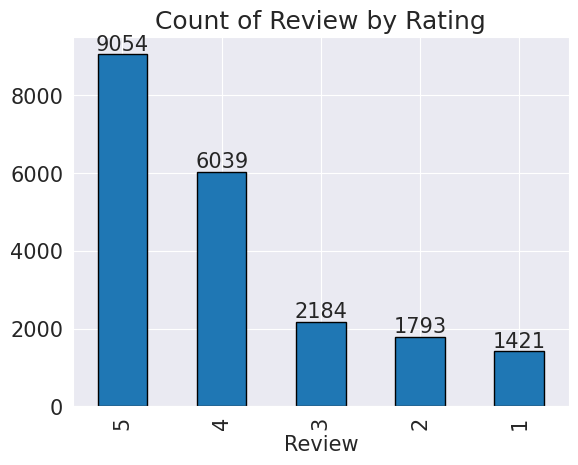

In [13]:
# Plotting the ratings
ax=data["Rating"].value_counts().plot(kind="bar",title="Count of Review by Rating", edgecolor="black")
for i in ax.containers:
  ax.bar_label(i)
  ax.set_xlabel("Review")
  plt.show()

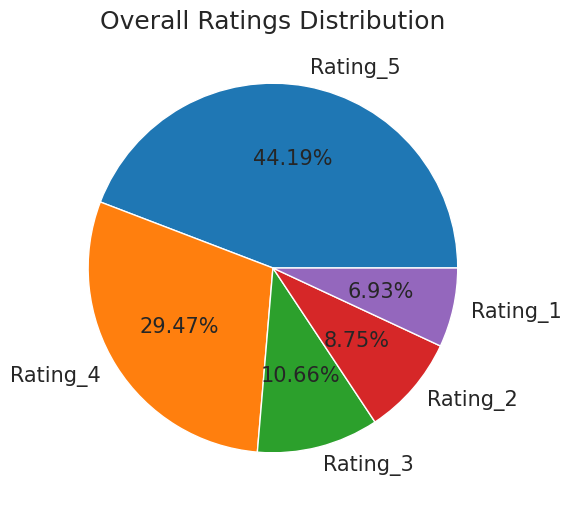

In [14]:
plt.figure(figsize=(8,6))
plt.pie(data['Rating'].value_counts(), labels =['Rating_5','Rating_4','Rating_3','Rating_2','Rating_1'], autopct='%.02f%%');
plt.title('Overall Ratings Distribution')
plt.show()

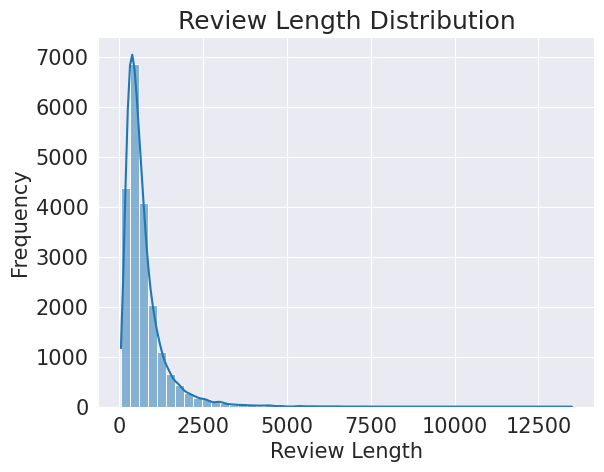

In [15]:
# Analyze the distribution of review lengths to understand the typical length of reviews.
# Create a new column for review lengths
data['review_length'] = data['Review'].apply(len)

# Visualize review length distribution
sns.histplot(data['review_length'], bins=50, kde=True)
plt.title('Review Length Distribution')
plt.xlabel('Review Length')
plt.ylabel('Frequency')
plt.show()

In [16]:
# Plotting most commonly used words in Reviews.
def plot_word_cloud(data,title):
  wc=WordCloud(width=800,height=600,collocations=False,max_words=300,background_color="black",random_state=1).generate(" ".join(data.values))
  plt.imshow(wc)
  plt.tight_layout(pad = 0)
  plt.title(title,fontsize=45)
  plt.axis("off")
  plt.show()

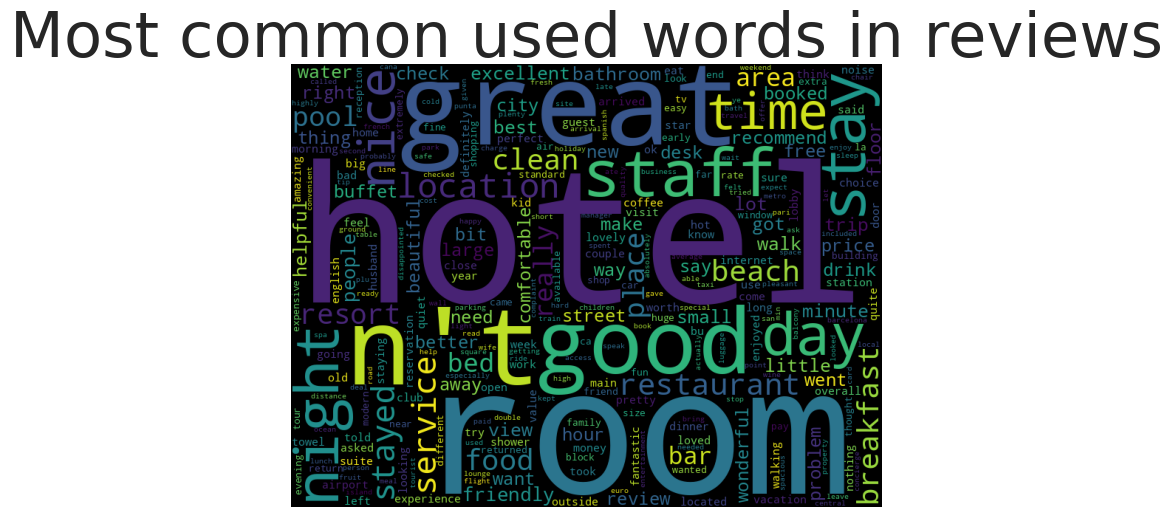

In [17]:
plot_word_cloud(data=data["Review"],title="Most common used words in reviews")

In [18]:
# Review
mostUsedWords = data['Review'].str.split(expand=True).stack().value_counts()
mostUsedWords_top200 = mostUsedWords[:200]
fig = px.treemap(mostUsedWords_top200, path=[mostUsedWords_top200.index], values=0)
fig.update_layout(title_text='The 200 Most Frequest Words',
title_x=0.5, title_font=dict(size=15))
fig.update_traces(textinfo="label+value")
fig.show()

# Data Preprocessing

In [19]:
stop_word=nltk.corpus.stopwords.words("english")
stopword=ENGLISH_STOP_WORDS
lemmatizer=WordNetLemmatizer()

In [20]:
#creating a Function for data cleaning
def clean_text(text):
  text=re.sub(r'\w*\d\w*','',str(text)).strip()    # removing numbers attached to the words
  text = re.sub("[\d]+", "", str(text))            # removing strings containg unwanted digits
  text = text.translate(str.maketrans('','',string.punctuation))   # removing punchuations
  text = re.sub('[%s]' % re.escape(string.punctuation), '', str(text))  # removing puncuations
  text = re.sub(r'[^\w\s]', " ", str(text))         # removing white spaces
  text = ' '.join( [w for w in text.split() if len(w)>1] )   #removing single characters
  text=text.split()
  text=" ".join([word for word in text if word not in stopword])   # removing stopwords
  text=nltk.word_tokenize(text)  # Tokenizing
  text=" ".join([lemmatizer.lemmatize(w,"v") for w in text])    # applying lemmatization
  text=" ".join(dict.fromkeys(text.split()))  # remove duplicate words
  return text

In [21]:
cleaned_review=[]  # list of cleaned reviews
for i in data["Review"]:
  cleaned_review.append(clean_text(i))

In [22]:
cleaned_review[:2]

['nice hotel expensive park get good deal stay anniversary arrive late even take advice previous review do valet check quick easy little disappoint nonexistent view room clean size bed comfortable wake stiff neck high pillow soundproof like hear music night morning loud bang doors open close people talk hallway maybe just noisy neighbor aveda bath products goldfish touch advantage longer location great walk distance shop overall experience have pay',
 'ok special charge diamond member hilton decide chain shoot anniversary seattle start book suite pay extra website description bedroom bathroom standard hotel room take print reservation desk show say things like tv couch ect clerk tell oh mix suit kimpton sorry free breakfast get kid embassy sit unlike call day stay offer correct false advertise send prefer guest email ask failure provide furnish hard copy printout manager duty do reply solution trip survey follow mail guess concern guestthe staff range indifferent helpful good spot neig

In [23]:
data["Cleaned_Review"]=cleaned_review
data.head()

,Review,Rating,review_length,Cleaned_Review
0,nice hotel expensive parking got good deal sta...,4,593,nice hotel expensive park get good deal stay a...
1,ok nothing special charge diamond member hilto...,2,1689,ok special charge diamond member hilton decide...
2,nice rooms not 4* experience hotel monaco seat...,3,1427,nice room experience hotel monaco seattle good...
3,"unique, great stay, wonderful time hotel monac...",5,600,unique great stay wonderful time hotel monaco ...
4,"great stay great stay, went seahawk game aweso...",5,1281,great stay go seahawk game awesome downfall vi...


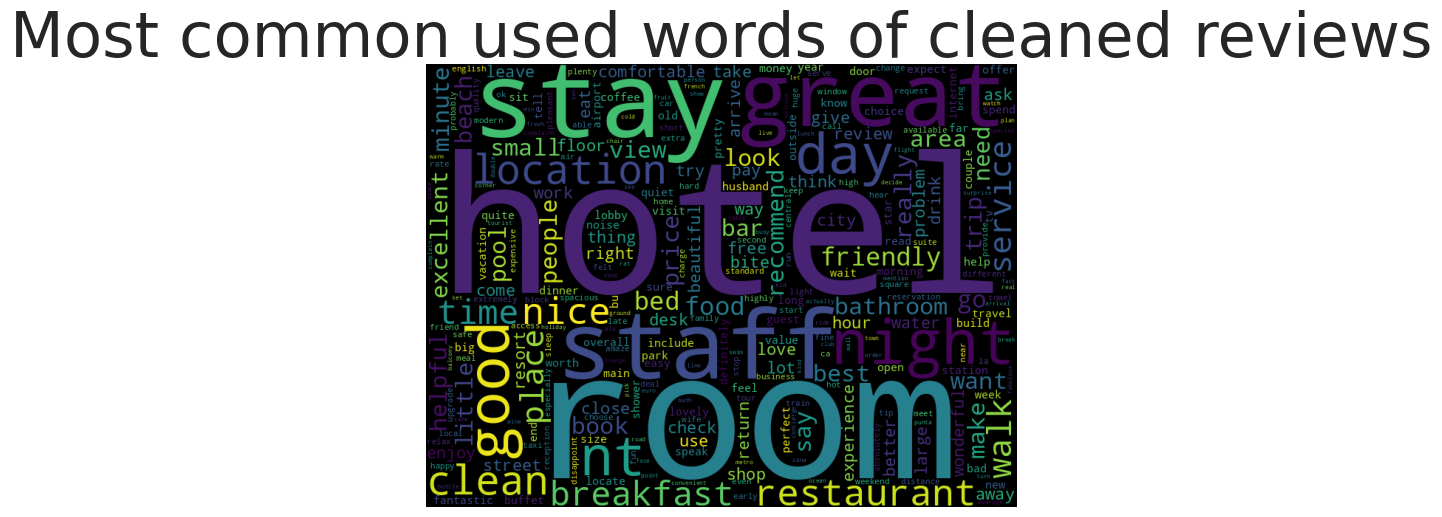

In [24]:
plot_word_cloud(data=data["Cleaned_Review"],title="Most common used words of cleaned reviews")

In [25]:
# Cleaned Review
mostUsedWords = data['Cleaned_Review'].str.split(expand=True).stack().value_counts()
mostUsedWords_top200 = mostUsedWords[:200]
fig = px.treemap(mostUsedWords_top200, path=[mostUsedWords_top200.index],values=0)
fig.update_layout(title_text='The 200 Most Frequest Words',
title_x=0.5, title_font=dict(size=15))
fig.update_traces(textinfo="label+value")
fig.show()

### Separating the positive and negative Reviews

In [26]:
def sentiments(x):
  if x<=2:
    return "Negative"
  else:
    return "Positive"
Sentiment_fun=lambda x:sentiments(x)

In [27]:
data["Sentiments"]=data["Rating"].apply(lambda x:sentiments(x))

In [28]:
data.head()

,Review,Rating,review_length,Cleaned_Review,Sentiments
0,nice hotel expensive parking got good deal sta...,4,593,nice hotel expensive park get good deal stay a...,Positive
1,ok nothing special charge diamond member hilto...,2,1689,ok special charge diamond member hilton decide...,Negative
2,nice rooms not 4* experience hotel monaco seat...,3,1427,nice room experience hotel monaco seattle good...,Positive
3,"unique, great stay, wonderful time hotel monac...",5,600,unique great stay wonderful time hotel monaco ...,Positive
4,"great stay great stay, went seahawk game aweso...",5,1281,great stay go seahawk game awesome downfall vi...,Positive


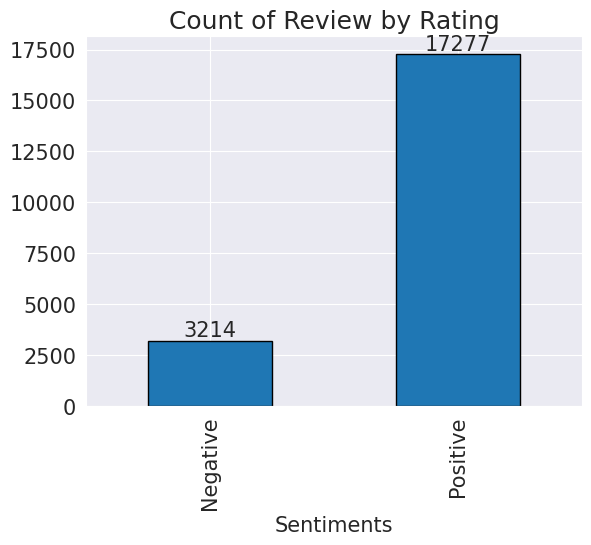

In [29]:
# lets take a look at the distribution of the reviews in terms of ratings after categorising the data into positive and negative sentiments
ax=data["Sentiments"].value_counts().sort_index().plot(kind="bar",title="Count of Review by Rating",edgecolor="black")
for i in ax.containers:
  ax.bar_label(i)
ax.set_xlabel("Sentiments")
plt.show()

# Sentimental Analysis

### Vader Sentiment Analysis

In [30]:
# Object Instantiation
nltk.download('vader_lexicon')
sia = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [31]:
def fetch_sentiment_using_SIA(text):
    sia = SentimentIntensityAnalyzer()
    polarity_scores = sia.polarity_scores(text)
    return 'Negative' if polarity_scores['neg'] > polarity_scores['pos'] else 'Positive'

In [32]:
# Applying the VADER function to entire data
data['SIA_Vader'] = data.Cleaned_Review.apply(lambda x: fetch_sentiment_using_SIA(x))

In [33]:
data.head()

,Review,Rating,review_length,Cleaned_Review,Sentiments,SIA_Vader
0,nice hotel expensive parking got good deal sta...,4,593,nice hotel expensive park get good deal stay a...,Positive,Positive
1,ok nothing special charge diamond member hilto...,2,1689,ok special charge diamond member hilton decide...,Negative,Positive
2,nice rooms not 4* experience hotel monaco seat...,3,1427,nice room experience hotel monaco seattle good...,Positive,Positive
3,"unique, great stay, wonderful time hotel monac...",5,600,unique great stay wonderful time hotel monaco ...,Positive,Positive
4,"great stay great stay, went seahawk game aweso...",5,1281,great stay go seahawk game awesome downfall vi...,Positive,Positive


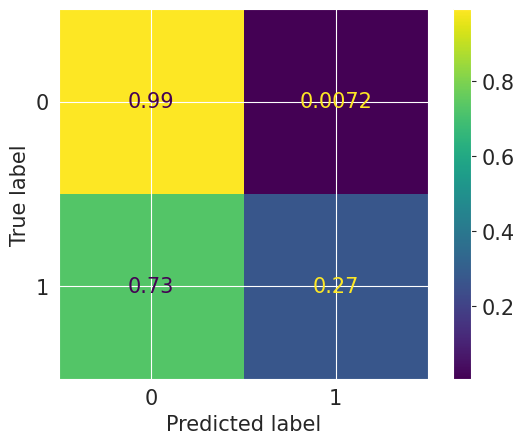

In [34]:
cm=confusion_matrix(data["Sentiments"],data["SIA_Vader"],normalize="true",labels=["Positive","Negative"])
cm_display=ConfusionMatrixDisplay(confusion_matrix=cm)
cm_display.plot()
plt.show()

In [35]:
Accuracy_Score_Vader=accuracy_score(data["Sentiments"],data["SIA_Vader"])
Accuracy_Score_Vader

0.8798496901078522

Total Count of Sentiments

Positive    95.119809
Negative     4.880191
Name: SIA_Vader, dtype: float64 



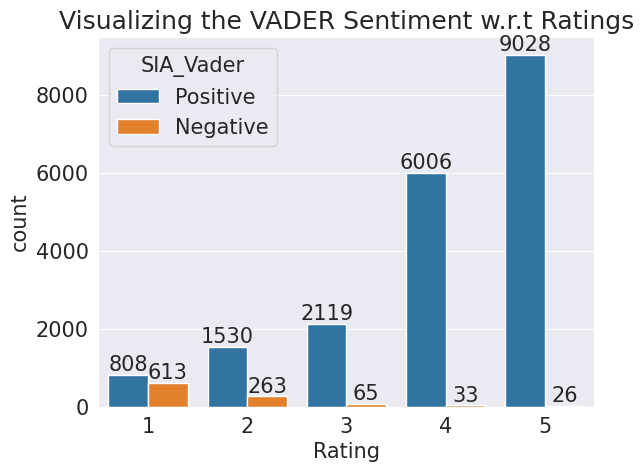

In [36]:
# Visualizing the Vader Sentiment Analysis
plt.title("Visualizing the VADER Sentiment w.r.t Ratings")
ax = sns.countplot(data = data , x = 'Rating', hue = 'SIA_Vader')
for i in ax.containers:
    ax.bar_label(i,)

print('Total Count of Sentiments\n')

print(data['SIA_Vader'].value_counts(['SIA_Vader'])*100, '\n')

### Polarity Sentimental Analysis


In [37]:
# Applying the TextBlob to entire data
data['TxtB_Polarity'] = data['Cleaned_Review'].apply(lambda x: TextBlob(x).sentiment[0])

In [38]:
data.head()

,Review,Rating,review_length,Cleaned_Review,Sentiments,SIA_Vader,TxtB_Polarity
0,nice hotel expensive parking got good deal sta...,4,593,nice hotel expensive park get good deal stay a...,Positive,Positive,0.157805
1,ok nothing special charge diamond member hilto...,2,1689,ok special charge diamond member hilton decide...,Negative,Positive,0.183042
2,nice rooms not 4* experience hotel monaco seat...,3,1427,nice room experience hotel monaco seattle good...,Positive,Positive,0.300569
3,"unique, great stay, wonderful time hotel monac...",5,600,unique great stay wonderful time hotel monaco ...,Positive,Positive,0.468056
4,"great stay great stay, went seahawk game aweso...",5,1281,great stay go seahawk game awesome downfall vi...,Positive,Positive,0.445000


In [39]:
data["Polarity_sentiment"] = ['Positive' if polarity > 0 else 'Negative' for polarity in data['TxtB_Polarity']]

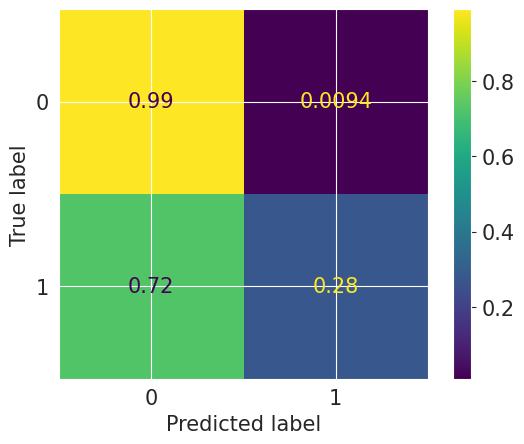

In [40]:
cm=confusion_matrix(data["Sentiments"],data["Polarity_sentiment"],normalize="true",labels=["Positive","Negative"])
cm_display=ConfusionMatrixDisplay(confusion_matrix=cm)
cm_display.plot()
plt.show()

In [41]:
Accuracy_Score_TxtB=accuracy_score(data["Sentiments"],data["Polarity_sentiment"])
Accuracy_Score_TxtB

0.8786784441950124

Total Count of Sentiments

Positive    94.866039
Negative     5.133961
Name: Polarity_sentiment, dtype: float64 



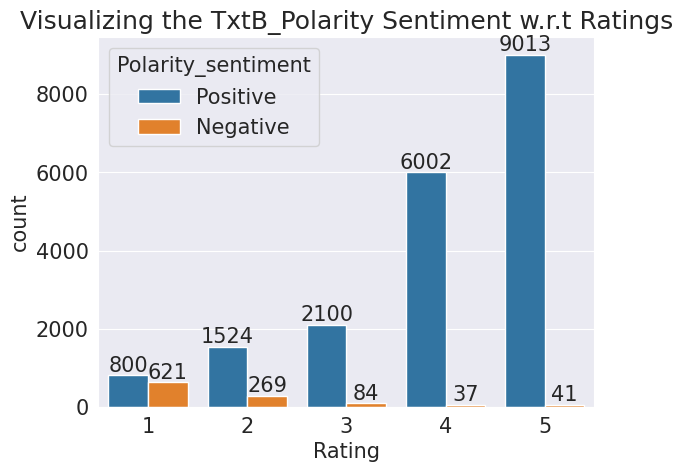

In [42]:
# Visualizing the TxtB_Polarity Sentiment Analysis
plt.title("Visualizing the TxtB_Polarity Sentiment w.r.t Ratings")
ax = sns.countplot(data = data , x = 'Rating', hue = 'Polarity_sentiment')
for i in ax.containers:
    ax.bar_label(i,)

print('Total Count of Sentiments\n')

print(data['Polarity_sentiment'].value_counts(['Polarity_sentiment'])*100, '\n')

### Affin Sentimental Analysis

In [43]:
# Object Instantiation
afn = Afinn()

In [44]:
# Applying afinn to dataset
data['Afinn_score'] = data['Cleaned_Review'].apply(lambda x: afn.score(x))

In [45]:
data.head()

,Review,Rating,review_length,Cleaned_Review,Sentiments,SIA_Vader,TxtB_Polarity,Polarity_sentiment,Afinn_score
0,nice hotel expensive parking got good deal sta...,4,593,nice hotel expensive park get good deal stay a...,Positive,Positive,0.157805,Positive,14.0
1,ok nothing special charge diamond member hilto...,2,1689,ok special charge diamond member hilton decide...,Negative,Positive,0.183042,Positive,27.0
2,nice rooms not 4* experience hotel monaco seat...,3,1427,nice room experience hotel monaco seattle good...,Positive,Positive,0.300569,Positive,12.0
3,"unique, great stay, wonderful time hotel monac...",5,600,unique great stay wonderful time hotel monaco ...,Positive,Positive,0.468056,Positive,22.0
4,"great stay great stay, went seahawk game aweso...",5,1281,great stay go seahawk game awesome downfall vi...,Positive,Positive,0.445000,Positive,18.0


In [46]:
# Defining a function for Vader Sentiment Analysis
def condition(x):
    if x>=20:
        return "Positive"
    else:
        return 'Negative'

In [47]:
# Applying condition on Afinn score
data['Affin_sentiment'] = data['Afinn_score'].apply(condition)

In [48]:
# Reviewing the data
data[['Cleaned_Review',  'Rating', 'Afinn_score', 'Affin_sentiment']]

,Cleaned_Review,Rating,Afinn_score,Affin_sentiment
0,nice hotel expensive park get good deal stay a...,4,14.0,Negative
1,ok special charge diamond member hilton decide...,2,27.0,Positive
2,nice room experience hotel monaco seattle good...,3,12.0,Negative
3,unique great stay wonderful time hotel monaco ...,5,22.0,Positive
4,great stay go seahawk game awesome downfall vi...,5,18.0,Negative
...,...,...,...,...
20486,best keep secret time stay charm star ca nt be...,5,24.0,Positive
20487,great location price view hotel quick place si...,4,10.0,Negative
20488,ok just look nice modern outside desk staff nt...,2,8.0,Negative
20489,hotel theft ruin vacation open sept guests wee...,1,13.0,Negative


In [49]:
data['Affin_sentiment'].value_counts()

Negative    14392
Positive     6099
Name: Affin_sentiment, dtype: int64

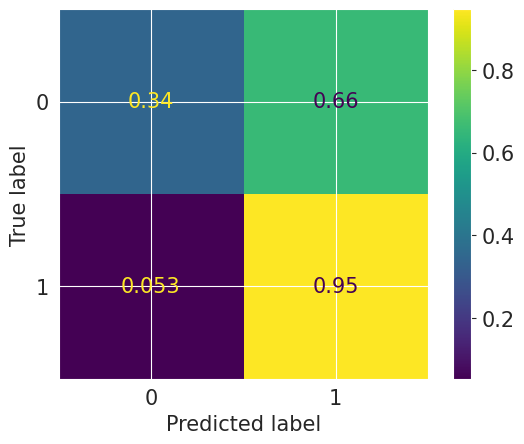

In [50]:
cm=confusion_matrix(data["Sentiments"],data["Affin_sentiment"],normalize="true",labels=["Positive","Negative"])
cm_display=ConfusionMatrixDisplay(confusion_matrix=cm)
cm_display.plot()
plt.show()

In [51]:
Accuracy_Score_Affin=accuracy_score(data["Sentiments"],data["Affin_sentiment"])
Accuracy_Score_Affin

0.437899565662974

Total Count of Sentiments

Negative    70.235713
Positive    29.764287
Name: Affin_sentiment, dtype: float64 



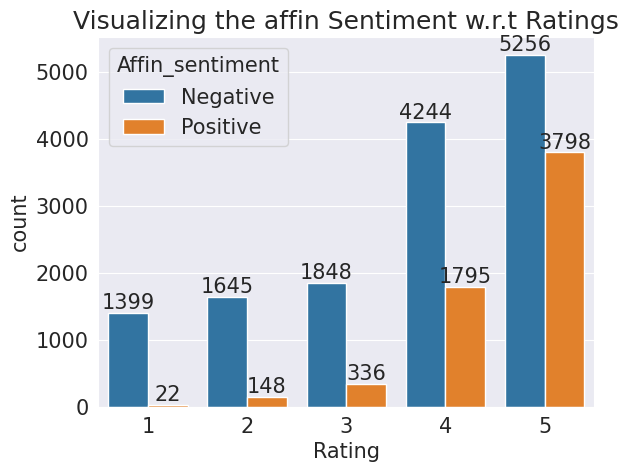

In [53]:
# Visualizing the Affin Sentiment Analysis
plt.title("Visualizing the affin Sentiment w.r.t Ratings")
ax = sns.countplot(data = data , x = 'Rating', hue = 'Affin_sentiment')
for i in ax.containers:
    ax.bar_label(i,)

print('Total Count of Sentiments\n')

print(data['Affin_sentiment'].value_counts(['Affin_sentiment'])*100, '\n')

In [54]:
print('Accuracy with Vader Sentiment Analysis      = ',Accuracy_Score_Vader*100,'%')
print('Accuracy with Txt Blob                      = ',Accuracy_Score_TxtB*100,'%')
print('Accuracy with Affin Sentiment Analysis      =',Accuracy_Score_Affin*100,'%')

Accuracy with Vader Sentiment Analysis      =  87.98496901078522 %
Accuracy with Txt Blob                      =  87.86784441950124 %
Accuracy with Affin Sentiment Analysis      = 43.7899565662974 %


From the above comparison we could understand that the performance of VADER Sentiment Analysis is best.

In [55]:
# Converting the ratings into two labels of Positive & Negative
data['Target'] = data['Rating'].apply(lambda x: 1 if x > 3 else 0)

# N-gram

In [56]:
# Bi-gram
def get_top_n2_words(corpus, n=None):
    vec1 = CountVectorizer(ngram_range=(2,2),  #for tri-gram, put ngram_range=(3,3)
            max_features=2000).fit(corpus)
    bag_of_words = vec1.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in
                  vec1.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1],
                reverse=True)
    return words_freq[:n]

In [57]:
top2_words = get_top_n2_words(data["Cleaned_Review"], n=200) #top 200
top2_df = pd.DataFrame(top2_words)
top2_df.columns=["Bi-gram", "Freq"]
top2_df.head(50)

,Bi-gram,Freq
0,do nt,1981
1,staff friendly,1874
2,great location,1348
3,friendly helpful,1213
4,walk distance,1160
5,just return,1132
6,punta cana,1104
7,highly recommend,1100
8,stay nights,1056
9,room clean,1024


<ipython-input-74-513004e2ab35>:3: UserWarning:

FixedFormatter should only be used together with FixedLocator



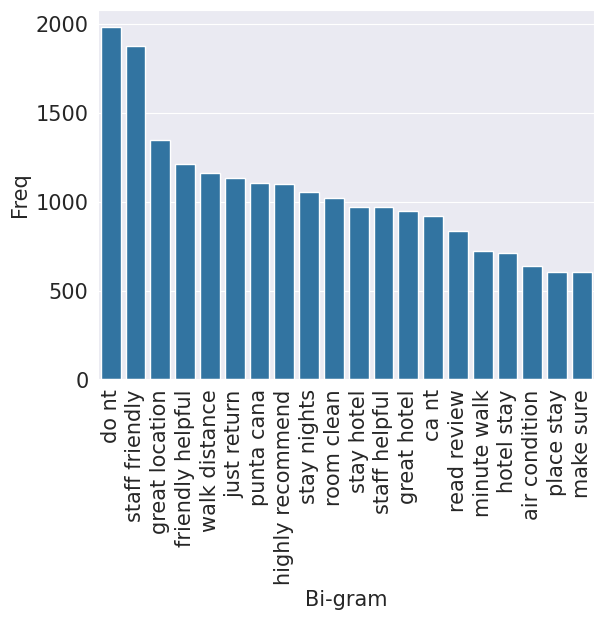

In [74]:
top20_bigram = top2_df.iloc[0:20,:]
plot=sns.barplot(x=top20_bigram["Bi-gram"],y=top20_bigram["Freq"])
plot.set_xticklabels(rotation=90,labels = top20_bigram["Bi-gram"]);

In [64]:
# Tri-gram
def get_top_n3_words(corpus, n=None):
    vec1 = CountVectorizer(ngram_range=(3,3),
           max_features=2000).fit(corpus)
    bag_of_words = vec1.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in
                  vec1.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1],
                reverse=True)
    return words_freq[:n]

In [65]:
top3_words = get_top_n3_words(data["Cleaned_Review"], n=200)
top3_df = pd.DataFrame(top3_words)
top3_df.columns=["Tri-gram", "Freq"]
top3_df

,Tri-gram,Freq
0,staff friendly helpful,639
1,flat screen tv,222
2,king size bed,202
3,just return night,186
4,hotel great location,184
...,...,...
195,upgrade junior suite,32
196,return week stay,32
197,stay punta cana,32
198,stay nights room,31


<ipython-input-75-8d865e5006ff>:3: UserWarning:

FixedFormatter should only be used together with FixedLocator



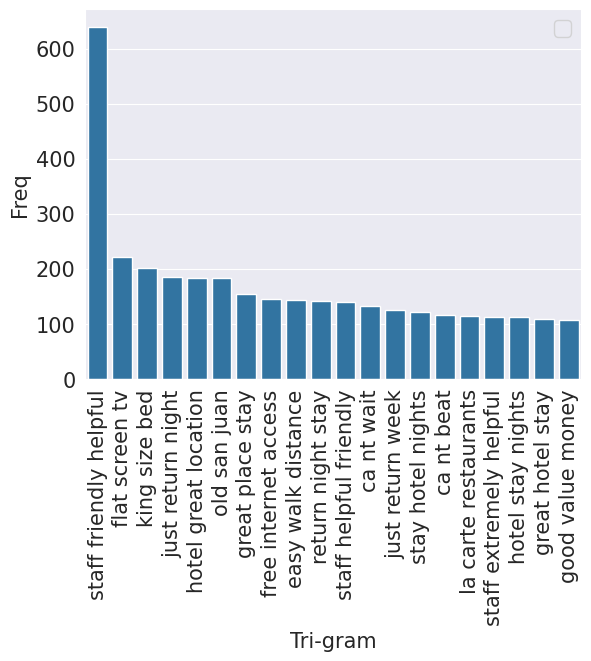

In [75]:
top20_trigram = top3_df.iloc[0:20,:]
plot=sns.barplot(x=top20_trigram["Tri-gram"],y=top20_trigram["Freq"])
plot.set_xticklabels(rotation=90,labels = top20_trigram["Tri-gram"]);
plt.legend()

# Feature Extraction

In [76]:
data.head()

,Review,Rating,review_length,Cleaned_Review,Sentiments,SIA_Vader,TxtB_Polarity,Polarity_sentiment,Afinn_score,Affin_sentiment,Target
0,nice hotel expensive parking got good deal sta...,4,593,nice hotel expensive park get good deal stay a...,Positive,Positive,0.157805,Positive,14.0,Negative,1
1,ok nothing special charge diamond member hilto...,2,1689,ok special charge diamond member hilton decide...,Negative,Positive,0.183042,Positive,27.0,Positive,0
2,nice rooms not 4* experience hotel monaco seat...,3,1427,nice room experience hotel monaco seattle good...,Positive,Positive,0.300569,Positive,12.0,Negative,0
3,"unique, great stay, wonderful time hotel monac...",5,600,unique great stay wonderful time hotel monaco ...,Positive,Positive,0.468056,Positive,22.0,Positive,1
4,"great stay great stay, went seahawk game aweso...",5,1281,great stay go seahawk game awesome downfall vi...,Positive,Positive,0.445000,Positive,18.0,Negative,1


# Model Builing Using Bag of Words

In [77]:
CV=CountVectorizer()
CV_Features=CV.fit_transform(data["Cleaned_Review"])
CV_Features[0]  # the data is converted into sparse matrix

<1x68890 sparse matrix of type '<class 'numpy.int64'>'
	with 69 stored elements in Compressed Sparse Row format>

In [78]:
CV.get_feature_names_out()[:50]

array(['aa', 'aaa', 'aaaa', 'aaaaa', 'aaaaaaaaa', 'aaaaaaaaaaaaaaa',
       'aaaare', 'aaah', 'aaahhh', 'aadvantage', 'aah', 'aahh',
       'aahhquiet', 'aalders', 'aand', 'aany', 'aaron', 'aarp', 'aarrgh',
       'aas', 'aavacationscom', 'ab', 'abac', 'aback', 'abaited',
       'abalone', 'abandon', 'abba', 'abbaye', 'abbelouie', 'abberation',
       'abbey', 'abbot', 'abbott', 'abbreviate', 'abby', 'abc', 'abd',
       'abderahim', 'abdication', 'abdomen', 'abdominal', 'abe',
       'abeautiful', 'abel', 'aber', 'abercrombie', 'aberdeen',
       'abessess', 'abetter'], dtype=object)

In [79]:
X=CV_Features  # X is the transformed matrix which we got after count vectorizer
y=data["Target"]

In [80]:
x_train1,x_test1,y_train1,y_test1 = train_test_split(X,y,test_size=0.25)

### Multinomial Naive Bayes

In [81]:
# Grid search
model_mnb1 = MultinomialNB()
params = {'alpha': [0.001,0.1,0.5,1.0,1.5,2.0,2.5,3]}
cv = KFold(n_splits=5, shuffle=True)
grid_search = GridSearchCV(model_mnb1, params)
grid_search.fit(x_train1, y_train1)
grid_search.best_params_
print(f'Best Params: {grid_search.best_params_}')
print(f'Best Score: {grid_search.best_score_}')

Best Params: {'alpha': 0.5}
Best Score: 0.8703153433444818


In [82]:
# Fitting the model with best parameters
model_mnb1 = MultinomialNB(alpha=0.5)
model_mnb1.fit(x_train1, y_train1)
y_pred_mnb1 = model_mnb1.predict(x_test1)
accuracy_mnb1 = accuracy_score(y_test1, y_pred_mnb1)
print(f'Accuracy score: {accuracy_mnb1}')

Accuracy score: 0.8666796798750732


In [83]:
# Classification report
cr=classification_report(y_test1, y_pred_mnb1)
print(cr)

              precision    recall  f1-score   support

           0       0.76      0.70      0.73      1311
           1       0.90      0.92      0.91      3812

    accuracy                           0.87      5123
   macro avg       0.83      0.81      0.82      5123
weighted avg       0.86      0.87      0.86      5123



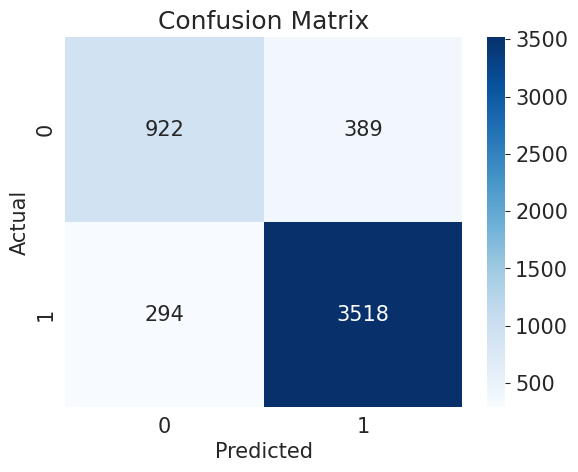

In [84]:
# Confusion matrix
cm = confusion_matrix(y_test1, y_pred_mnb1)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=model_mnb1.classes_, yticklabels=model_mnb1.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

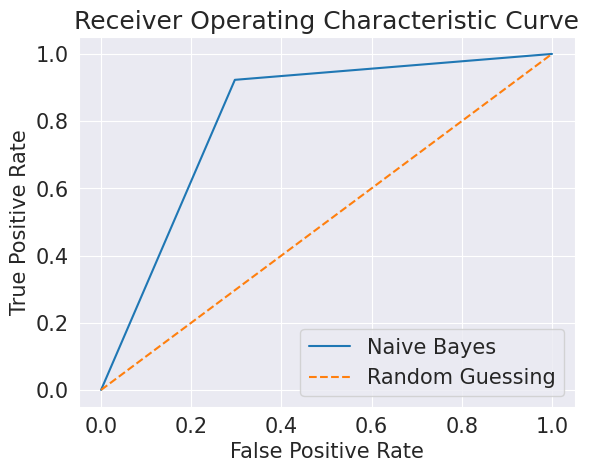

In [85]:
# ROC curve
fpr,tpr,thresholds=roc_curve(y_test1,y_pred_mnb1)
plt.plot(fpr,tpr,label='Naive Bayes')
plt.plot([0, 1], [0, 1], '--', label='Random Guessing')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Curve')
plt.legend()
plt.show()

In [86]:
print(f'false positive rate: {fpr}')
print(f'true positive rate: {tpr}')
print(f'thresholds: {thresholds}')

false positive rate: [0.         0.29672006 1.        ]
true positive rate: [0.         0.92287513 1.        ]
thresholds: [2 1 0]


### K-Nearest Neighbour

In [87]:
# Grid search
model_knn1 = KNeighborsClassifier()
params = {'n_neighbors':[2,3,4,5,6,7,8,9,10]}
cv = KFold(n_splits=5, shuffle=True)
grid_search = GridSearchCV(model_knn1, params)
grid_search.fit(x_train1, y_train1)
grid_search.best_params_
print(f'Best Params: {grid_search.best_params_}')
print(f'Best Score: {grid_search.best_score_}')

Best Params: {'n_neighbors': 6}
Best Score: 0.7602819147438359


In [88]:
# Fitting the model with best parameters
model_knn1 = KNeighborsClassifier(n_neighbors=6, metric='euclidean')
model_knn1.fit(x_train1, y_train1)
y_pred_knn1 = model_knn1.predict(x_test1)
accuracy_knn1 = accuracy_score(y_test1, y_pred_knn1)
print(f'Accuracy score: {accuracy_knn1}')

Accuracy score: 0.7753269568612141


In [89]:
# Classification report
cr=classification_report(y_test1, y_pred_knn1)
print(cr)

              precision    recall  f1-score   support

           0       0.67      0.24      0.35      1311
           1       0.79      0.96      0.86      3812

    accuracy                           0.78      5123
   macro avg       0.73      0.60      0.61      5123
weighted avg       0.76      0.78      0.73      5123



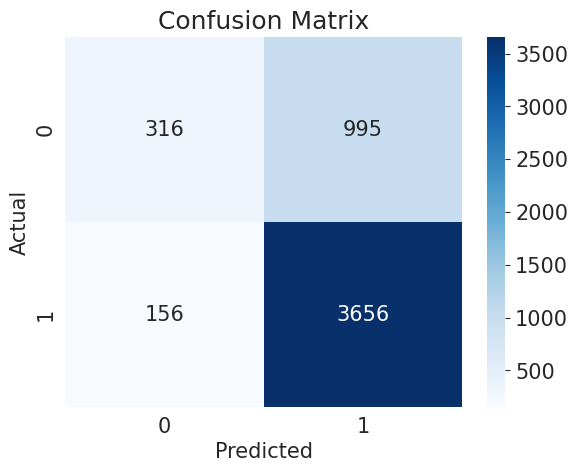

In [90]:
# Confusion matrix
cm = confusion_matrix(y_test1, y_pred_knn1)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=model_knn1.classes_, yticklabels=model_knn1.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

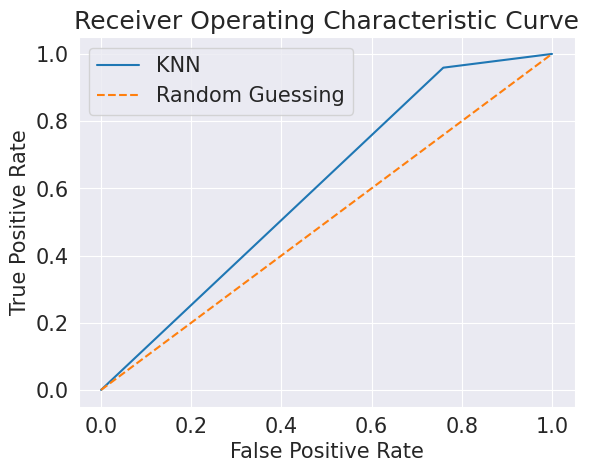

In [91]:
# ROC curve
fpr,tpr,thresholds=roc_curve(y_test1, y_pred_knn1)
plt.plot(fpr,tpr,label='KNN')
plt.plot([0, 1], [0, 1], '--', label='Random Guessing')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Curve')
plt.legend()
plt.show()

In [92]:
print(f'false positive rate: {fpr}')
print(f'true positive rate: {tpr}')
print(f'thresholds: {thresholds}')

false positive rate: [0.         0.75896262 1.        ]
true positive rate: [0.        0.9590766 1.       ]
thresholds: [2 1 0]


### Random Forest Classifier

In [93]:
# Grid search
model_rf1 = RandomForestClassifier()
params = {'n_estimators': [50, 100, 150, 200, 250, 300],'max_depth': [5, 7, 9, 11, 13,]}
grid_search = GridSearchCV(model_rf1, params)
grid_search.fit(x_train1, y_train1)
grid_search.best_params_
print(f'Best Params: {grid_search.best_params_}')
print(f'Best Score: {grid_search.best_score_}')

Best Params: {'max_depth': 13, 'n_estimators': 50}
Best Score: 0.737636721367564


In [94]:
# Fitting the model with best parameters
model_rf1 = RandomForestClassifier(n_estimators=50,max_features='auto',max_depth=13)
model_rf1.fit(x_train1, y_train1)
y_pred_rf1 = model_rf1.predict(x_test1)
accuracy_rf1 = accuracy_score(y_test1, y_pred_rf1)
print(f'Accuracy score: {accuracy_rf1}')

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.



Accuracy score: 0.7479992192074956


In [95]:
# Classification report
cr=classification_report(y_test1, y_pred_rf1)
print(cr)

              precision    recall  f1-score   support

           0       0.95      0.02      0.03      1311
           1       0.75      1.00      0.86      3812

    accuracy                           0.75      5123
   macro avg       0.85      0.51      0.44      5123
weighted avg       0.80      0.75      0.64      5123



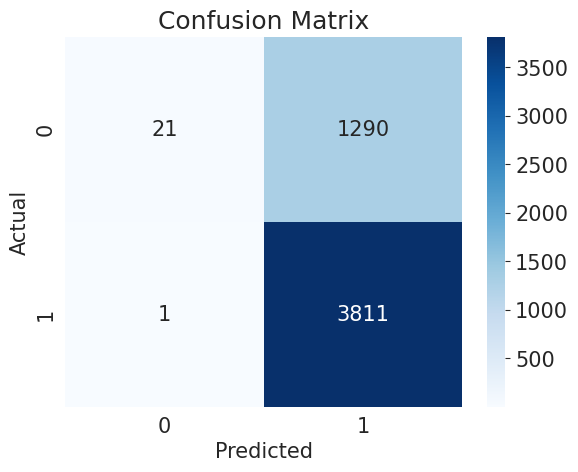

In [96]:
# Confusion matrix
cm = confusion_matrix(y_test1, y_pred_rf1)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=model_rf1.classes_, yticklabels=model_rf1.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

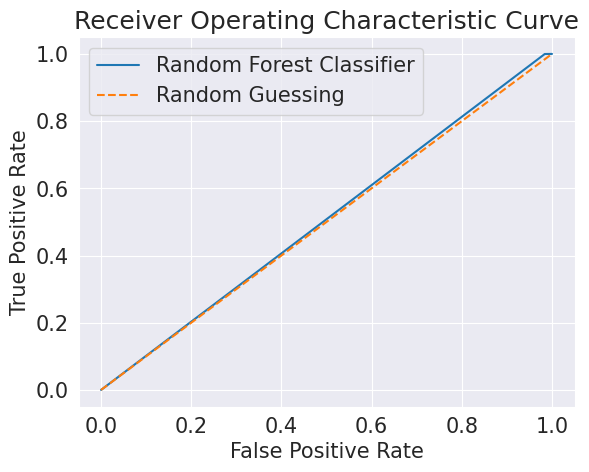

In [97]:
# ROC curve
fpr,tpr,thresholds=roc_curve(y_test1,y_pred_rf1)
plt.plot(fpr,tpr,label='Random Forest Classifier')
plt.plot([0, 1], [0, 1], '--', label='Random Guessing')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Curve')
plt.legend()
plt.show()

In [98]:
print(f'false positive rate: {fpr}')
print(f'true positive rate: {tpr}')
print(f'thresholds: {thresholds}')

false positive rate: [0.         0.98398169 1.        ]
true positive rate: [0.         0.99973767 1.        ]
thresholds: [2 1 0]


# Support Vector Classifier

In [ ]:
# Grid search
model_svc1= SVC()
params = {'C': [0.1, 1, 10, 100, 1000],'gamma': [1, 0.1, 0.01, 0.001, 0.0001]}
cv = KFold(n_splits=5, shuffle=True)
grid_search = GridSearchCV(model_svc1, params)
grid_search.fit(x_train1, y_train1)
grid_search.best_params_
print(f'Best Params: {grid_search.best_params_}')
print(f'Best Score: {grid_search.best_score_}')

In [100]:
# Fitting the model with best parameters
model_svc1 = SVC(C=10, kernel='rbf', degree=50, gamma=1)
model_svc1.fit(x_train1, y_train1)
y_pred_svc1 = model_svc1.predict(x_test1)
accuracy_svc1 = accuracy_score(y_test1, y_pred_svc1)
print(f'Accuracy score: {accuracy_svc1}')

Accuracy score: 0.7442904548116338


In [101]:
# Classification report
cr=classification_report(y_test1, y_pred_svc1)
print(cr)

              precision    recall  f1-score   support

           0       1.00      0.00      0.00      1311
           1       0.74      1.00      0.85      3812

    accuracy                           0.74      5123
   macro avg       0.87      0.50      0.43      5123
weighted avg       0.81      0.74      0.64      5123



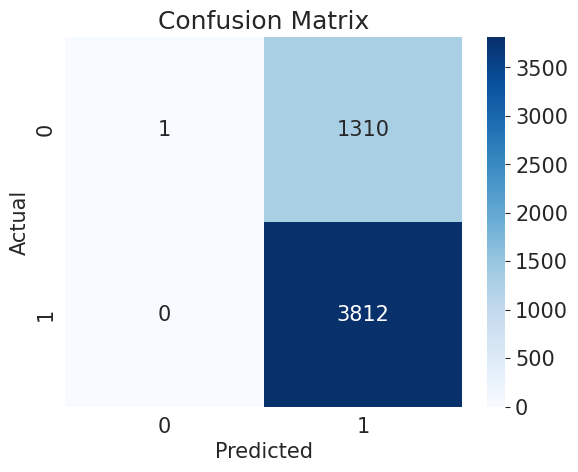

In [102]:
# Confusion matrix
cm = confusion_matrix(y_test1, y_pred_svc1)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=model_svc1.classes_, yticklabels=model_svc1.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

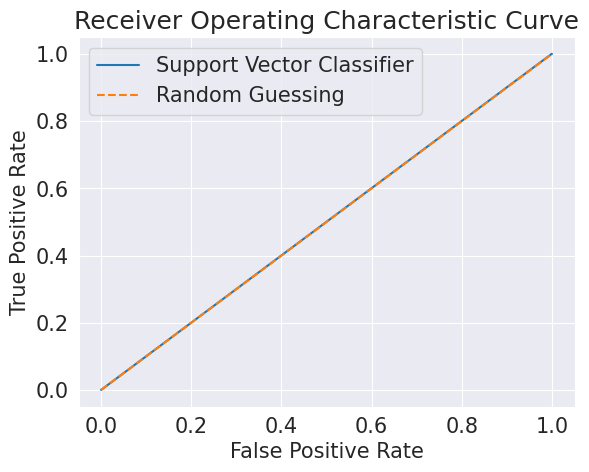

In [103]:
# ROC curve
fpr,tpr,thresholds=roc_curve(y_test1,y_pred_svc1)
plt.plot(fpr,tpr,label='Support Vector Classifier')
plt.plot([0, 1], [0, 1], '--', label='Random Guessing')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Curve')
plt.legend()
plt.show()

In [104]:
print(f'false positive rate: {fpr}')
print(f'true positive rate: {tpr}')
print(f'thresholds: {thresholds}')

false positive rate: [0.         0.99923722 1.        ]
true positive rate: [0. 1. 1.]
thresholds: [2 1 0]


### Decision Tree

In [105]:
# Grid search
model_dt1 = DecisionTreeClassifier()
params = {'criterion':['gini','entropy'],'splitter':['best','random'],'max_depth':[1,2,3,4,5,6,7,8,9,10]}
grid_search = GridSearchCV(model_dt1, params)
grid_search.fit(x_train1, y_train1)
grid_search.best_params_
print(f'Best Params: {grid_search.best_params_}')
print(f'Best Score: {grid_search.best_score_}')

Best Params: {'criterion': 'gini', 'max_depth': 10, 'splitter': 'best'}
Best Score: 0.7805183179796921


In [106]:
# Fitting the model with best parameters
model_dt1 = DecisionTreeClassifier(criterion='gini', splitter='best', max_depth=10)
model_dt1.fit(x_train1, y_train1)
y_pred_dt1 = model_dt1.predict(x_test1)
accuracy_dt1 = accuracy_score(y_test1, y_pred_dt1)
print(f'Accuracy score: {accuracy_dt1}')

Accuracy score: 0.7938707788405232


In [107]:
# Classification report
cr=classification_report(y_test1, y_pred_dt1)
print(cr)

              precision    recall  f1-score   support

           0       0.59      0.61      0.60      1311
           1       0.87      0.86      0.86      3812

    accuracy                           0.79      5123
   macro avg       0.73      0.73      0.73      5123
weighted avg       0.80      0.79      0.79      5123



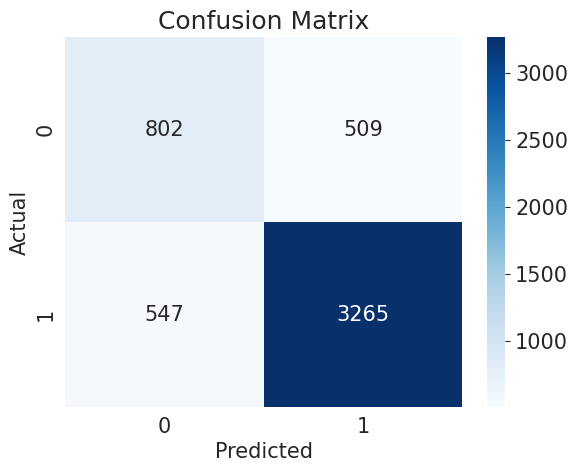

In [108]:
# Confusion matrix
cm = confusion_matrix(y_test1, y_pred_dt1)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels = model_dt1.classes_, yticklabels = model_dt1.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

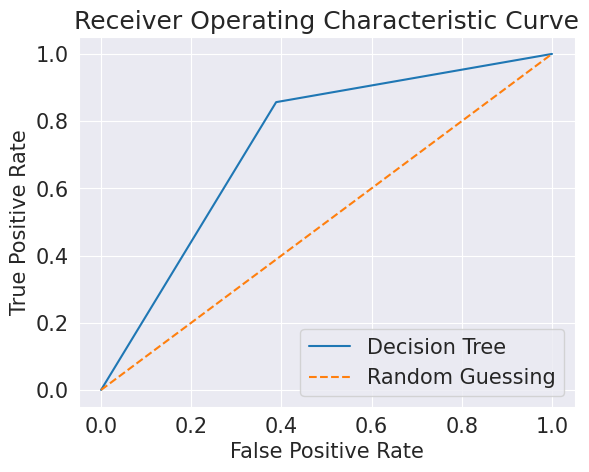

In [109]:
# ROC curve
fpr,tpr,thresholds=roc_curve(y_test1,y_pred_dt1)
plt.plot(fpr,tpr,label='Decision Tree')
plt.plot([0, 1], [0, 1], '--', label='Random Guessing')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Curve')
plt.legend()
plt.show()

In [110]:
print(f'false positive rate: {fpr}')
print(f'true positive rate: {tpr}')
print(f'thresholds: {thresholds}')

false positive rate: [0.         0.38825324 1.        ]
true positive rate: [0.         0.85650577 1.        ]
thresholds: [2 1 0]


In [111]:
print('Multinomial Naive Bayes  = ',accuracy_mnb1*100,'%')
print('KNN = ',accuracy_knn1*100,'%')
print('Random Forest Classifier = ',accuracy_rf1*100,'%')
print('Support Vector Classifier  = ',accuracy_svc1*100,'%')
print('Decision Tree = ',accuracy_dt1*100,'%')

Multinomial Naive Bayes  =  86.66796798750732 %
KNN =  77.53269568612141 %
Random Forest Classifier =  74.79992192074955 %
Support Vector Classifier  =  74.42904548116339 %
Decision Tree =  79.38707788405232 %


# Model Builing Using TFIDF

In [112]:
TFIDF=TfidfVectorizer()
TFIDF_Features=TFIDF.fit_transform(data["Cleaned_Review"])

In [113]:
X=TFIDF_Features
y=data["Target"]

In [114]:
x_train2,x_test2,y_train2,y_test2 = train_test_split(X,y,test_size=0.25)

### Multinomial Naive Bayes

In [115]:
# Grid search
model_mnb2 = MultinomialNB()
params = {'alpha': [0.001,0.1,0.5,1.0,1.5,2.0,2.5,3]}
cv = KFold(n_splits=5, shuffle=True)
grid_search = GridSearchCV(model_mnb2, params)
grid_search.fit(x_train2, y_train2)
grid_search.best_params_
print(f'Best Params: {grid_search.best_params_}')
print(f'Best Score: {grid_search.best_score_}')

Best Params: {'alpha': 0.1}
Best Score: 0.8480609442621647


In [116]:
# Fitting the model with best parameters
model_mnb2 = MultinomialNB(alpha=0.1)
model_mnb2.fit(x_train2, y_train2)
y_pred_mnb2 = model_mnb2.predict(x_test2)
accuracy_mnb2 = accuracy_score(y_test2, y_pred_mnb2)
print(f'Accuracy score: {accuracy_mnb2}')

Accuracy score: 0.8526254147960179


In [117]:
# Classification report
cr=classification_report(y_test2, y_pred_mnb2)
print(cr)

              precision    recall  f1-score   support

           0       0.84      0.55      0.67      1371
           1       0.85      0.96      0.91      3752

    accuracy                           0.85      5123
   macro avg       0.85      0.76      0.79      5123
weighted avg       0.85      0.85      0.84      5123



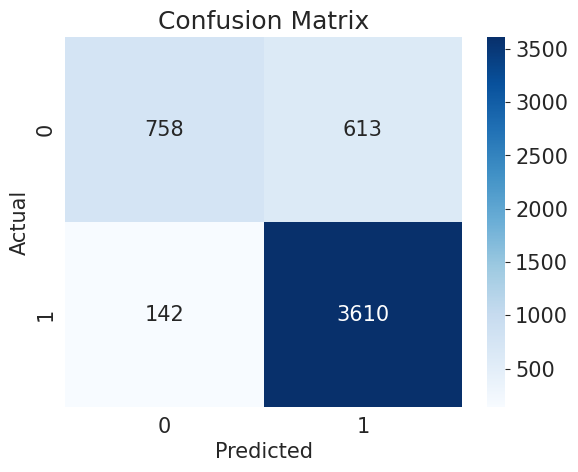

In [118]:
# Confusion matrix
cm = confusion_matrix(y_test2, y_pred_mnb2)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=model_mnb2.classes_, yticklabels=model_mnb2.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

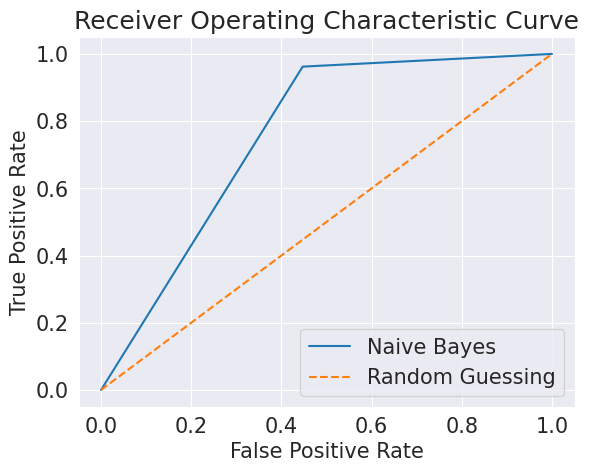

In [119]:
# ROC curve
fpr,tpr,thresholds=roc_curve(y_test2,y_pred_mnb2)
plt.plot(fpr,tpr,label='Naive Bayes')
plt.plot([0, 1], [0, 1], '--', label='Random Guessing')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Curve')
plt.legend()
plt.show()

In [120]:
print(f'false positive rate: {fpr}')
print(f'true positive rate: {tpr}')
print(f'thresholds: {thresholds}')

false positive rate: [0.         0.44711889 1.        ]
true positive rate: [0.         0.96215352 1.        ]
thresholds: [2 1 0]


### K-Nearest Neighbour

In [ ]:
# Grid search
model_knn2 = KNeighborsClassifier()
params = {'n_neighbors':[2,3,4,5,6,7,8,9,10]}
cv = KFold(n_splits=5, shuffle=True)
grid_search = GridSearchCV(model_knn2, params)
grid_search.fit(x_train2, y_train2)
grid_search.best_params_
print(f'Best Params: {grid_search.best_params_}')
print(f'Best Score: {grid_search.best_score_}')

In [122]:
# Fitting the model with best parameters
model_knn2 = KNeighborsClassifier(n_neighbors=3, metric='euclidean')
model_knn2.fit(x_train2, y_train2)
y_pred_knn2 = model_knn2.predict(x_test2)
accuracy_knn2 = accuracy_score(y_test2, y_pred_knn2)
print(f'Accuracy score: {accuracy_knn2}')

Accuracy score: 0.7991411282451688


In [123]:
# Classification report
cr=classification_report(y_test2, y_pred_knn2)
print(cr)

              precision    recall  f1-score   support

           0       0.75      0.37      0.50      1371
           1       0.81      0.96      0.87      3752

    accuracy                           0.80      5123
   macro avg       0.78      0.66      0.69      5123
weighted avg       0.79      0.80      0.77      5123



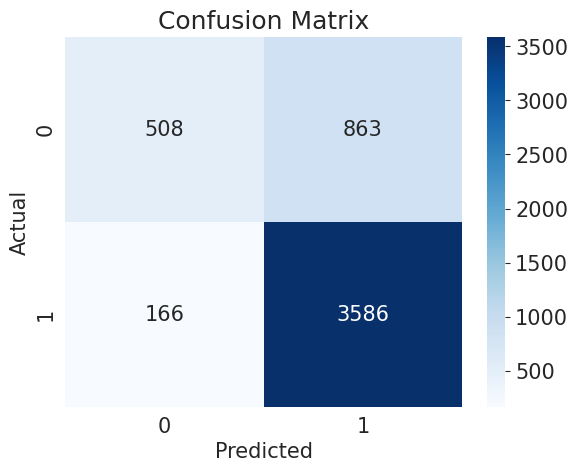

In [124]:
# Confusion matrix
cm = confusion_matrix(y_test2, y_pred_knn2)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=model_knn2.classes_, yticklabels=model_knn2.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

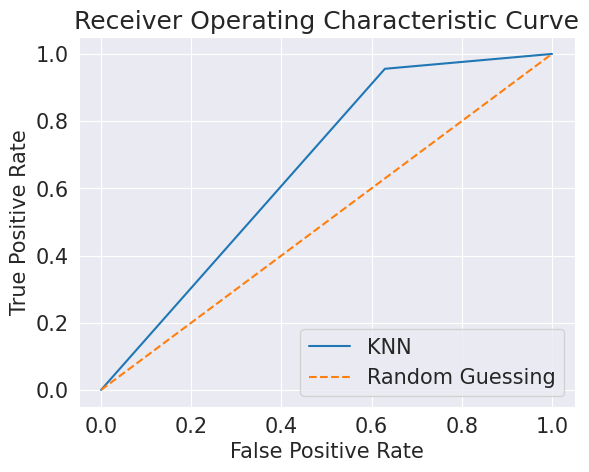

In [125]:
# ROC curve
fpr,tpr,thresholds=roc_curve(y_test2, y_pred_knn2)
plt.plot(fpr,tpr,label='KNN')
plt.plot([0, 1], [0, 1], '--', label='Random Guessing')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Curve')
plt.legend()
plt.show()

In [126]:
print(f'false positive rate: {fpr}')
print(f'true positive rate: {tpr}')
print(f'thresholds: {thresholds}')

false positive rate: [0.         0.62946754 1.        ]
true positive rate: [0.         0.95575693 1.        ]
thresholds: [2 1 0]


### Random Forest Classifier

In [ ]:
# Grid search
model_rf2 = RandomForestClassifier()
params = {'n_estimators': [50, 100, 150, 200, 250, 300],'max_depth': [5, 7, 9, 11, 13,]}
grid_search = GridSearchCV(model_rf2, params)
grid_search.fit(x_train2, y_train2)
grid_search.best_params_
print(f'Best Params: {grid_search.best_params_}')
print(f'Best Score: {grid_search.best_score_}')

In [128]:
# Fitting the model with best parameters
model_rf2 = RandomForestClassifier(n_estimators=100,max_features='auto',max_depth=13)
model_rf2.fit(x_train2, y_train2)
y_pred_rf2 = model_rf2.predict(x_test2)
accuracy_rf2 = accuracy_score(y_test2, y_pred_rf2)
print(f'Accuracy score: {accuracy_rf2}')

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.



Accuracy score: 0.7343353503806364


In [129]:
# Classification report
cr=classification_report(y_test2, y_pred_rf2)
print(cr)

              precision    recall  f1-score   support

           0       1.00      0.01      0.01      1371
           1       0.73      1.00      0.85      3752

    accuracy                           0.73      5123
   macro avg       0.87      0.50      0.43      5123
weighted avg       0.81      0.73      0.62      5123



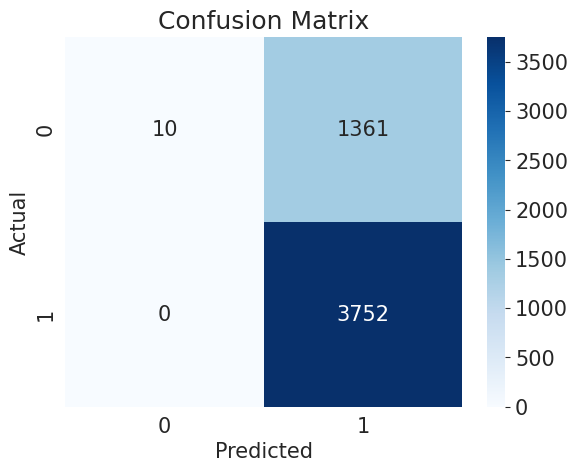

In [131]:
# Confusion matrix
cm = confusion_matrix(y_test2, y_pred_rf2)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=model_rf2.classes_, yticklabels=model_rf2.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

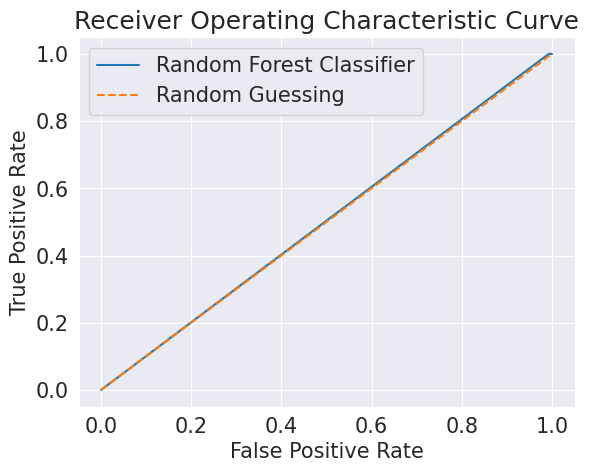

In [132]:
# ROC curve
fpr,tpr,thresholds=roc_curve(y_test2,y_pred_rf2)
plt.plot(fpr,tpr,label='Random Forest Classifier')
plt.plot([0, 1], [0, 1], '--', label='Random Guessing')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Curve')
plt.legend()
plt.show()

In [133]:
print(f'false positive rate: {fpr}')
print(f'true positive rate: {tpr}')
print(f'thresholds: {thresholds}')

false positive rate: [0.         0.99270605 1.        ]
true positive rate: [0. 1. 1.]
thresholds: [2 1 0]


### Support Vector Classifier

In [ ]:
# Grid search
model_svc2= SVC()
params = {'C': [0.1, 1, 10, 100, 1000],'gamma': [1, 0.1, 0.01, 0.001, 0.0001]}
cv = KFold(n_splits=5, shuffle=True)
grid_search = GridSearchCV(model_svc2, params)
grid_search.fit(x_train2, y_train2)
grid_search.best_params_
print(f'Best Params: {grid_search.best_params_}')
print(f'Best Score: {grid_search.best_score_}')

In [135]:
# Fitting the model with best parameters
model_svc2 = SVC(C=10, kernel='rbf', degree=50, gamma=1)
model_svc2.fit(x_train2, y_train2)
y_pred_svc2 = model_svc2.predict(x_test2)
accuracy_svc2 = accuracy_score(y_test2, y_pred_svc2)
print(f'Accuracy score: {accuracy_svc2}')

Accuracy score: 0.8914698418895178


In [137]:
# Classification report
cr=classification_report(y_test2, y_pred_svc2)
print(cr)

              precision    recall  f1-score   support

           0       0.86      0.71      0.78      1371
           1       0.90      0.96      0.93      3752

    accuracy                           0.89      5123
   macro avg       0.88      0.83      0.85      5123
weighted avg       0.89      0.89      0.89      5123



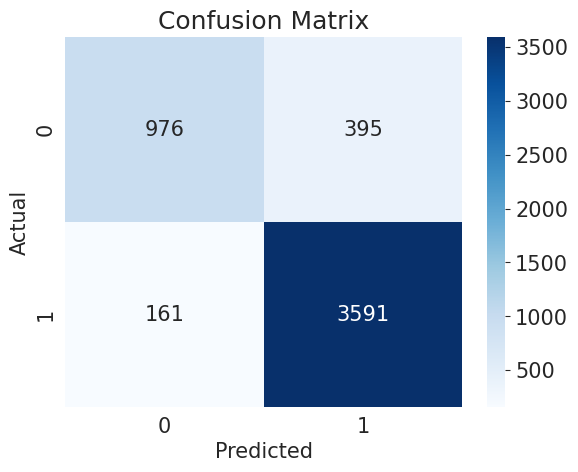

In [138]:
# Confusion matrix
cm = confusion_matrix(y_test2, y_pred_svc2)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=model_svc2.classes_, yticklabels=model_svc2.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

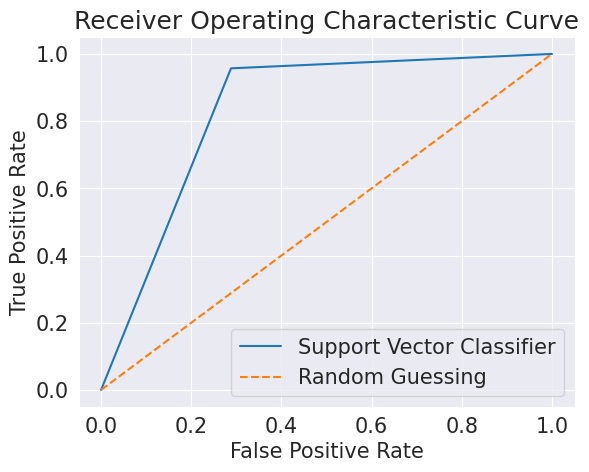

In [139]:
# ROC curve
fpr,tpr,thresholds=roc_curve(y_test2,y_pred_svc2)
plt.plot(fpr,tpr,label='Support Vector Classifier')
plt.plot([0, 1], [0, 1], '--', label='Random Guessing')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Curve')
plt.legend()
plt.show()

In [140]:
print(f'false positive rate: {fpr}')
print(f'true positive rate: {tpr}')
print(f'thresholds: {thresholds}')

false positive rate: [0.         0.28811087 1.        ]
true positive rate: [0.         0.95708955 1.        ]
thresholds: [2 1 0]


### Decision Tree

In [ ]:
# Grid search
model_dt2 = DecisionTreeClassifier()
params = {'criterion':['gini','entropy'],'splitter':['best','random'],'max_depth':[1,2,3,4,5,6,7,8,9,10]}
grid_search = GridSearchCV(model_dt2, params)
grid_search.fit(x_train2, y_train2)
grid_search.best_params_
print(f'Best Params: {grid_search.best_params_}')
print(f'Best Score: {grid_search.best_score_}')

In [141]:
# Fitting the model with best parameters
model_dt2 = DecisionTreeClassifier(criterion='gini', splitter='best', max_depth=10)
model_dt2.fit(x_train2, y_train2)
y_pred_dt2 = model_dt2.predict(x_test2)
accuracy_dt2 = accuracy_score(y_test2, y_pred_dt2)
print(f'Accuracy score: {accuracy_dt2}')

Accuracy score: 0.7659574468085106


In [142]:
# Classification report
cr=classification_report(y_test2, y_pred_dt2)
print(cr)

              precision    recall  f1-score   support

           0       0.56      0.58      0.57      1371
           1       0.85      0.83      0.84      3752

    accuracy                           0.77      5123
   macro avg       0.70      0.71      0.71      5123
weighted avg       0.77      0.77      0.77      5123



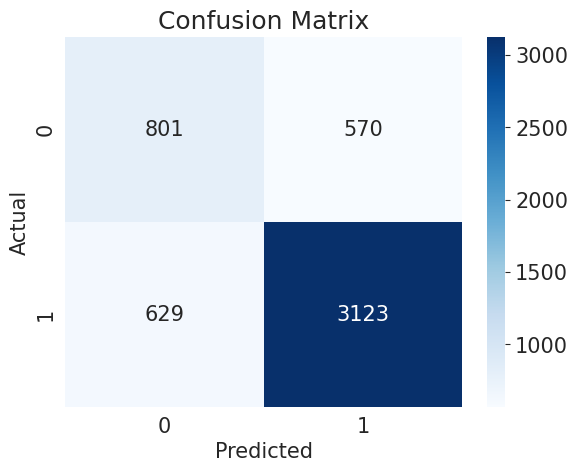

In [143]:
# Confusion matrix
cm = confusion_matrix(y_test2, y_pred_dt2)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels = model_dt2.classes_, yticklabels = model_dt2.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

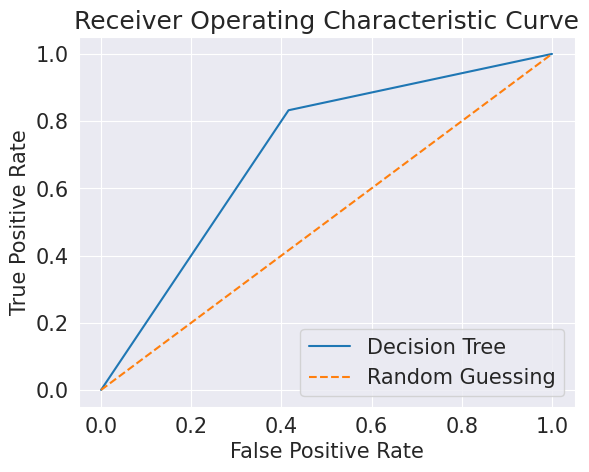

In [144]:
# ROC curve
fpr,tpr,thresholds=roc_curve(y_test2,y_pred_dt2)
plt.plot(fpr,tpr,label='Decision Tree')
plt.plot([0, 1], [0, 1], '--', label='Random Guessing')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Curve')
plt.legend()
plt.show()

In [145]:
print(f'false positive rate: {fpr}')
print(f'true positive rate: {tpr}')
print(f'thresholds: {thresholds}')

false positive rate: [0.         0.41575492 1.        ]
true positive rate: [0.         0.83235608 1.        ]
thresholds: [2 1 0]


In [146]:
print('Multinomial Naive Bayes  = ',accuracy_mnb2*100,'%')
print('KNN = ',accuracy_knn2*100,'%')
print('Random Forest Classifier = ',accuracy_rf2*100,'%')
print('Support Vector Classifier   = ',accuracy_svc2*100,'%')
print('Decision Tree = ',accuracy_dt2*100,'%')

Multinomial Naive Bayes  =  85.2625414796018 %
KNN =  79.91411282451688 %
Random Forest Classifier =  73.43353503806364 %
Support Vector Classifier   =  89.14698418895178 %
Decision Tree =  76.59574468085107 %


Anong all the five models we used Support Vector Classifier gives the best accuracy score of 89.14%

In [147]:
from sklearn.pipeline import Pipeline

In [148]:
X=data["Cleaned_Review"]
y=data["Target"]

In [149]:
clf=Pipeline([("tfidf",TfidfVectorizer()),("classifier",SVC())])
clf

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('classifier', SVC())])

In [150]:
clf.fit(X,y)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('classifier', SVC())])

In [151]:
x_train,x_test,y_train,y_test = train_test_split(X,y,test_size=0.25)

In [152]:
y_pred=clf.predict(x_test)

In [153]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       1.00      0.96      0.98      1371
           1       0.98      1.00      0.99      3752

    accuracy                           0.99      5123
   macro avg       0.99      0.98      0.98      5123
weighted avg       0.99      0.99      0.99      5123



In [154]:
clf.predict(["This hotel is amazing"])

array([1])

In [155]:
clf.predict(["This is horrible"])

array([0])

In [156]:
import pickle
pickle.dump(clf,open("Hotel_Review_Analysis.pkl","wb"))

In [157]:
pickle.dump(clean_text("review"),open("cleaned_data.pkl","wb"))

In [158]:
! pip install streamlit -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 16.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.4/196.4 kB 18.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 33.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.0/83.0 kB 10.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 8.0 MB/s eta 0:00:00


In [162]:
! streamlit run HotelReview.py & npx localtunnel --port 8501

[..................] / rollbackFailedOptional: verb npm-session 4a2a329449bcf49


  You can now view your Streamlit app in your browser.

  Network URL: http://172.28.0.12:8501
  External URL: http://34.106.96.186:8501

npx: installed 22 in 3.445s
your url is: https://two-pants-begin.loca.lt
  Stopping...
^C
